In [1]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import pandas
from scipy import stats
from numpy import matlib
import matplotlib.path as mpath
import matplotlib.ticker as mticker 
import cartopy.crs as ccrs
import cartopy.feature as cf
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import mlab
from scipy import integrate

## Read the daily temperature and U

### FOCI-HIST

In [51]:
%cd -b sw060
sw060_t = xr.open_dataset('FOCI1.7-SW060_echam6_echam_1958-2013_st_pl.nc', decode_times=True)
sw060_t = sw060_t.sel(plev=slice(100000, 100), time=slice('1958-01-01', '2002-12-31'))
%cd -b sw061
sw061_t = xr.open_dataset('FOCI1.7-SW061_echam6_echam_1958-2013_st_pl.nc', decode_times=True)
sw061_t = sw061_t.sel(plev=slice(100000, 100), time=slice('1958-01-01', '2002-12-31'))
%cd -b jh019
jh019_t = xr.open_dataset('FOCI1.9.4-JH019_echam6_echam_1958-2013_st_pl.nc', decode_times=True)
jh019_t = jh019_t.sel(plev=slice(100000, 100), time=slice('1958-01-01', '2002-12-31'))

(bookmark:sw060) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.7-SW060/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.7-SW060/outdata/echam6
(bookmark:sw061) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.7-SW061/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.7-SW061/outdata/echam6
(bookmark:jh019) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.9.4-JH019/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.9.4-JH019/outdata/echam6


### FOCI-MOZ

In [53]:
%cd -b sw054
sw054_t = xr.open_dataset('FOCI1.4-SW054_echam6_echam_1958-2013_st_pl.nc', decode_times=True)
sw054_t = sw054_t.sel(plev=slice(100000, 100), time=slice('1958-01-01', '2002-12-31'))
%cd -b sw064
sw064_t = xr.open_dataset('FOCI1.4-SW064_echam6_echam_1958-2013_st_pl.nc', decode_times=True)
sw064_t = sw064_t.sel(plev=slice(100000, 100), time=slice('1958-01-01', '2002-12-31'))
%cd -b sw065
sw065_t = xr.open_dataset('FOCI1.4-SW065_echam6_echam_1958-2013_st_pl.nc', decode_times=True)
sw065_t = sw065_t.sel(plev=slice(100000, 100), time=slice('1958-01-01', '2002-12-31'))

(bookmark:sw054) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW054/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW054/outdata/echam6
(bookmark:sw064) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW064/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW064/outdata/echam6
(bookmark:sw065) -> /sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW065/outdata/echam6
/sfs/fs1/work-geomar/smomw418/models/foci/experiments/FOCI1.4-SW065/outdata/echam6


In [54]:
%cd /sfs/fs2/work-geomar7/smomw235/era5/
era_t = xr.open_dataset('E5_1950-2019_T_T63_daymean.nc', decode_times=True)
era_t = era_t.sel(time=slice('1958-01-01', '2002-12-31'))

/sfs/fs2/work-geomar7/smomw235/era5


In [55]:
%cd /sfs/fs1/work-geomar/smomw418/observations/IGRA/
igra = xr.open_dataset('IGRA_ANT_stations_combined_T_1958-2002_pl_daily.nc', decode_times=True).__xarray_dataarray_variable__

/sfs/fs1/work-geomar/smomw418/observations/IGRA


## Select relevant latitudes

In [57]:
sw054f_t = sw054_t.st.sel(lat=slice(-65, -90)).mean(dim='lon').mean(dim='lat')
sw064f_t = sw064_t.st.sel(lat=slice(-65, -90)).mean(dim='lon').mean(dim='lat')
sw065f_t = sw065_t.st.sel(lat=slice(-65, -90)).mean(dim='lon').mean(dim='lat')
print('First done')
sw060f_t = sw060_t.st.sel(lat=slice(-65, -90)).mean(dim='lon').mean(dim='lat')
sw061f_t = sw061_t.st.sel(lat=slice(-65, -90)).mean(dim='lon').mean(dim='lat')
jh019f_t = jh019_t.st.sel(lat=slice(-65, -90)).mean(dim='lon').mean(dim='lat')

First done


In [58]:
eraf_t = era_t.T.sel(lat=slice(-65, -90)).mean(dim='lon').mean(dim='lat')

In [61]:
def mann_kendall(data):
    
    time = data.year
    plev = data.plev
    day = data.day
    trend = xr.DataArray(np.zeros((len(plev), len(day))), dims=['plev', 'day'], coords = [plev, day])
    
    for i in range(0, len(time)-1):
        val = data.sel(year=time[i]) # select each value in the array
        sign = xr.where(data>val, 1, 2) # put 1 where following values are greater than val
        sign = xr.where(data<val, -1, sign) # put -1 where following values are smaller than val
        sign = xr.where(data==val, 0, sign) # put 0 where following values are equal to val
        trend = trend + sign[:,i+1::,:].sum(dim='year')
        no_equal = sign.where(sign==0).count(dim='year')-1
    
    # Compute the variance
    var = 1/18*(len(time)*(len(time)-1)*(2*len(time)+5))
    
    # Compute the normalized test statistic
    z = xr.where(trend>0, (trend-1)/np.sqrt(var), 0)
    z = xr.where(trend<0, (trend+1)/np.sqrt(var), z)
    
    # Compute the probability associated with the test statistic
    p = 1/np.sqrt(2*np.pi)*np.exp(z**2/(-2))
    
    # Form array with 1 where the trend is significant and 0 elsewhere
    signif = xr.where(p<0.05, 1, 0)
    
    return signif

In [62]:
def sel_days(data):
    def is_day(day, d, month, m):
        return (day==d) & (month==m) # returns an array with true where the day of the year is d and false elswhere
    
    # 1st of Janary
    data_out = data.sel(time=is_day(data['time.day'],1, data['time.month'],1)).groupby('time.year').mean(dim='time')

    # January
    for d in range(2,32):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],1)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # February
    for d in range(1,29):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],2)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # March
    for d in range(1,32):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],3)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # April
    for d in range(1,31):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],4)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # May
    for d in range(1,32):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],5)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # June
    for d in range(1,31):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],6)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # July
    for d in range(1,32):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],7)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # August
    for d in range(1,32):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],8)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # September
    for d in range(1,31):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],9)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # October
    for d in range(1,32):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],10)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # November
    for d in range(1,31):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],11)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    # December
    for d in range(1,32):
        data_day = data.sel(time=is_day(data['time.day'],d, data['time.month'],12)).groupby('time.year').mean(dim='time')
        data_out = xr.concat((data_out, data_day), dim='day')
    
    day = np.arange(1,366)
    data_out = data_out.assign_coords(day=day)
    
    return data_out

## Ensemble mean trends

In [63]:
def ii_ens_trend_time_plev(data):
       
    # Select the calendar day
    mon = sel_days(data)
    
    # Compute the linear trend using least squares method
    time = mon.year
    t = np.arange(1,len(time)+1)
    trend = np.zeros((len(mon.plev), len(mon.day)))
    for i in range(0, len(mon.plev)):
        for j in range(0, len(mon.day)):
            trend[i,j], _, _, _, _ = stats.linregress(t, mon[j,:,i].values) # linear regression of x from time
            
    trend = xr.DataArray(trend*10, dims=['plev', 'day'], coords=[mon.plev, mon.day])

    # Check the significance using the Mann-Kendall test
    sig = mann_kendall(mon) #1 where the trend is significant and 0 elsewhere

    signif = xr.where(sig==1, trend, np.nan)
    non_sig = xr.where(sig==0, 1, np.nan)
    
    # Compute the time mean for each day
    mean = mon.mean(dim='year')
    
    return trend, signif, mean

In [64]:
def ii_ens_trend_igra(data):
       
    # Select the calendar day
    mon = sel_days(data)
    
    # Compute the linear trend using least squares method
    time = mon.year
    t = np.arange(1,len(time)+1)
    trend = np.zeros((len(mon.plev), len(mon.day)))*np.nan
    for i in range(0, len(mon.plev)):
        for j in range(0, len(mon.day)):
            m = mon[j,:,i].values
            mask = ~np.isnan(m)
            if m[mask]!=[]:
                trend[i,j], _, _, _, _ = stats.linregress(t[mask], m[mask]) # linear regression of x from time
            
    trend = xr.DataArray(trend*10, dims=['plev', 'day'], coords=[mon.plev, mon.day])

    # Check the significance using the Mann-Kendall test
    sig = mann_kendall(mon) #1 where the trend is significant and 0 elsewhere

    signif = xr.where(sig==1, trend, np.nan)
    non_sig = xr.where(sig==0, 1, np.nan)
    
    # Compute the time mean for each day
    mean = mon.mean(dim='year')
    
    return trend, signif, mean

In [65]:
def ii_ens_trend_time(data):
       
    # Select the calendar day
    mon = ii_sel_months(data)
    
    # Compute the linear trend using least squares method
    time = mon.year
    t = np.arange(1,len(time)+1)
    trend = np.zeros((len(mon.month)))
    for j in range(0, len(mon.month)):
        trend[j], _, _, _, _ = stats.linregress(t, mon[j,:].values) # linear regression of x from time
            
    trend = xr.DataArray(trend*10, dims=['month'], coords=[mon.month])

    # Check the significance using the Mann-Kendall test
    sig = mann_kendall_time(mon) #1 where the trend is significant and 0 elsewhere

    signif = xr.where(sig==1, trend, np.nan)
    non_sig = xr.where(sig==0, 1, np.nan)
    
    # Compute the time mean for each day
    mean = mon.mean(dim='year')
    
    return trend, signif, mean

In [66]:
def ens_trend(data1, data2, data3):
    
    # Compute the ensemble mean
    ens = xr.concat((data1, data2, data3), dim='exp').mean(dim='exp')
    print('Ensemble mean done')
    
    # Compute the ensemble mean trend and its significance
    #trend, signif, mean = ii_ens_trend_time_plev(ens)
    trend, signif, mean = ii_ens_trend_time_plev(ens)
    
    return trend, signif, mean

In [67]:
histf_trend_t, histf_signif_t, histf_mean_t = ens_trend(sw060f_t, sw061f_t, jh019f_t)
mozf_trend_t, mozf_signif_t, mozf_mean_t = ens_trend(sw065f_t, sw064f_t, sw054f_t)

Ensemble mean done
Ensemble mean done


In [68]:
sw060f_trend_t, sw060f_signif_t, sw060f_mean_t = ii_ens_trend_time_plev(sw060f_t)
sw061f_trend_t, sw061f_signif_t, sw061f_mean_t = ii_ens_trend_time_plev(sw061f_t)
jh019f_trend_t, jh019f_signif_t, jh019f_mean_t = ii_ens_trend_time_plev(jh019f_t)

sw054f_trend_t, sw054f_signif_t, sw054f_mean_t = ii_ens_trend_time_plev(sw054f_t)
sw064f_trend_t, sw064f_signif_t, sw064f_mean_t = ii_ens_trend_time_plev(sw064f_t)
sw065f_trend_t, sw065f_signif_t, sw065f_mean_t = ii_ens_trend_time_plev(sw065f_t)

In [69]:
eraf_trend_t, eraf_signif_t, eraf_mean_t = ii_ens_trend_time_plev(eraf_t)

In [31]:
igra_trend_t, igra_signif_t, igra_mean_t = ii_ens_trend_igra(igra)

/sfs/fs6/home-geomar/smomw418/miniconda3/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/sfs/fs6/home-geomar/smomw418/miniconda3/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/sfs/fs6/home-geomar/smomw418/miniconda3/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/sfs/fs6/home-geomar/smomw418/miniconda3/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/sfs/fs6/home-geomar/smomw418/miniconda3/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/sfs/fs6/home-geomar/smomw418/miniconda3/envs/py3/lib/python

In [73]:
def mon_plev(trend, sign, mean, cont, cont2, ticks, title,n):
    
    # Start on the 1st of July
    trend = xr.concat((trend[:,181::], trend[:,0:181]), dim='day') 
    signn = xr.concat((sign[:,181::], sign[:,0:181]), dim='day')
    mean =  xr.concat((mean[181::,:], mean[0:181,:]), dim='day')
    
    day = np.arange(1,366)
    mon_mark = np.array([15, 46, 77, 107, 138, 168, 199, 230, 258, 289, 319, 350]) # mark the 15th of every month
    
    plt.subplot(2,4,n)
    con = plt.contourf(day, trend.plev/100, trend, cont, cmap='RdBu_r', extend='both', hatches=['.'])
    con = plt.contourf(day, trend.plev/100, signn, cont, cmap='RdBu_r', extend='both')
    cs = plt.contour(day, trend.plev/100, mean.transpose(), cont2, colors='k')
    plt.clabel(cs, fmt= '%1.0f', fontsize=20, inline=1)
    plt.xlim(day.min(), day.max())
    plt.ylim(1, 1000)
    ax=plt.gca()
    ax.invert_yaxis()
    ax.set_yscale('log')
    plt.xticks(mon_mark, ('J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J')) # mark the 15th of every month
    plt.yticks([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
               ('1', '2', '5', '10', '20', '50', '100', '200', '500', '1000'))
    ax.tick_params(axis='both', labelsize=28)
    ax.minorticks_on()
    plt.ylabel('Pressure (hPa)', fontsize=28) 
    plt.title(title, fontsize=28)
    
    return con
    

In [74]:
def mon_plev2(trend, sign, mean, cont, cont2, ticks, title,n):
    
    # Start on the 1st of July
    trend = xr.concat((trend[:,181::], trend[:,0:181]), dim='day') 
    signn = xr.concat((sign[:,181::], sign[:,0:181]), dim='day')
    mean =  xr.concat((mean[181::,:], mean[0:181,:]), dim='day')
    
    day = np.arange(1,366)
    mon_mark = np.array([15, 46, 77, 107, 138, 168, 199, 230, 258, 289, 319, 350]) # mark the 15th of every month
    
    plt.subplot(2,4,n)
    con = plt.contourf(day, trend.plev/100, trend, cont, cmap='RdBu_r', extend='both', hatches=['.'])
    con = plt.contourf(day, trend.plev/100, signn, cont, cmap='RdBu_r', extend='both')
    cs = plt.contour(day, trend.plev/100, mean.transpose(), cont2, colors='k')
    plt.clabel(cs, fmt= '%1.0f', fontsize=20, inline=1)
    plt.xlim(day.min(), day.max())
    plt.ylim(1, 1000)
    ax=plt.gca()
    ax.invert_yaxis()
    ax.set_yscale('log')
    plt.xticks(mon_mark, ('J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J')) # mark the 15th of every month
    plt.yticks([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
               ())
    ax.tick_params(axis='both', labelsize=28)
    ax.minorticks_on()
    #plt.ylabel('Pressure (hPa)', fontsize=30) 
    plt.title(title, fontsize=28)
    
    return con
    

In [75]:
def mon_plev3(trend, sign, mean, cont, cont2, ticks, title,n):
    
    # Start on the 1st of July
    trend = xr.concat((trend[:,181::], trend[:,0:181]), dim='day') 
    signn = xr.concat((sign[:,181::], sign[:,0:181]), dim='day')
    mean =  xr.concat((mean[181::,:], mean[0:181,:]), dim='day')
    
    day = np.arange(1,366)
    mon_mark = np.array([15, 46, 77, 107, 138, 168, 199, 230, 258, 289, 319, 350]) # mark the 15th of every month
    
    plt.subplot(2,4,n)
    con = plt.contourf(day, trend.plev/100, trend, cont, cmap='RdBu_r', extend='both', hatches=['.'])
    con = plt.contourf(day, trend.plev/100, signn, cont, cmap='RdBu_r', extend='both')
    cs = plt.contour(day, trend.plev/100, mean.transpose(), cont2, colors='k')
    plt.clabel(cs, fmt= '%1.0f', fontsize=20, inline=1)
    plt.xlim(day.min(), day.max())
    plt.ylim(1, 1000)
    ax=plt.gca()
    ax.invert_yaxis()
    ax.set_yscale('log')
    plt.xticks(mon_mark, ()) # mark the 15th of every month
    plt.yticks([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
               ('1', '2', '5', '10', '20', '50', '100', '200', '500', '1000'))
    ax.tick_params(axis='both', labelsize=28)
    ax.minorticks_on()
    plt.ylabel('Pressure (hPa)', fontsize=28) 
    plt.title(title, fontsize=28)
    
    return con
    

In [76]:
def mon_plev4(trend, sign, mean, cont, cont2, ticks, title,n):
    
    # Start on the 1st of July
    trend = xr.concat((trend[:,181::], trend[:,0:181]), dim='day') 
    signn = xr.concat((sign[:,181::], sign[:,0:181]), dim='day')
    mean =  xr.concat((mean[181::,:], mean[0:181,:]), dim='day')
    
    day = np.arange(1,366)
    mon_mark = np.array([15, 46, 77, 107, 138, 168, 199, 230, 258, 289, 319, 350]) # mark the 15th of every month
    
    plt.subplot(2,4,n)
    con = plt.contourf(day, trend.plev/100, trend, cont, cmap='RdBu_r', extend='both', hatches=['.'])
    con = plt.contourf(day, trend.plev/100, signn, cont, cmap='RdBu_r', extend='both')
    cs = plt.contour(day, trend.plev/100, mean.transpose(), cont2, colors='k')
    plt.clabel(cs, fmt= '%1.0f', fontsize=20, inline=1)
    plt.xlim(day.min(), day.max())
    plt.ylim(1, 1000)
    ax=plt.gca()
    ax.invert_yaxis()
    ax.set_yscale('log')
    plt.xticks(mon_mark, ()) # mark the 15th of every month
    plt.yticks([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
               ())
    ax.tick_params(axis='both', labelsize=28)
    ax.minorticks_on()
    #plt.ylabel('Pressure (hPa)', fontsize=30) 
    plt.title(title, fontsize=28)
    
    return con
    

## 65S-90S

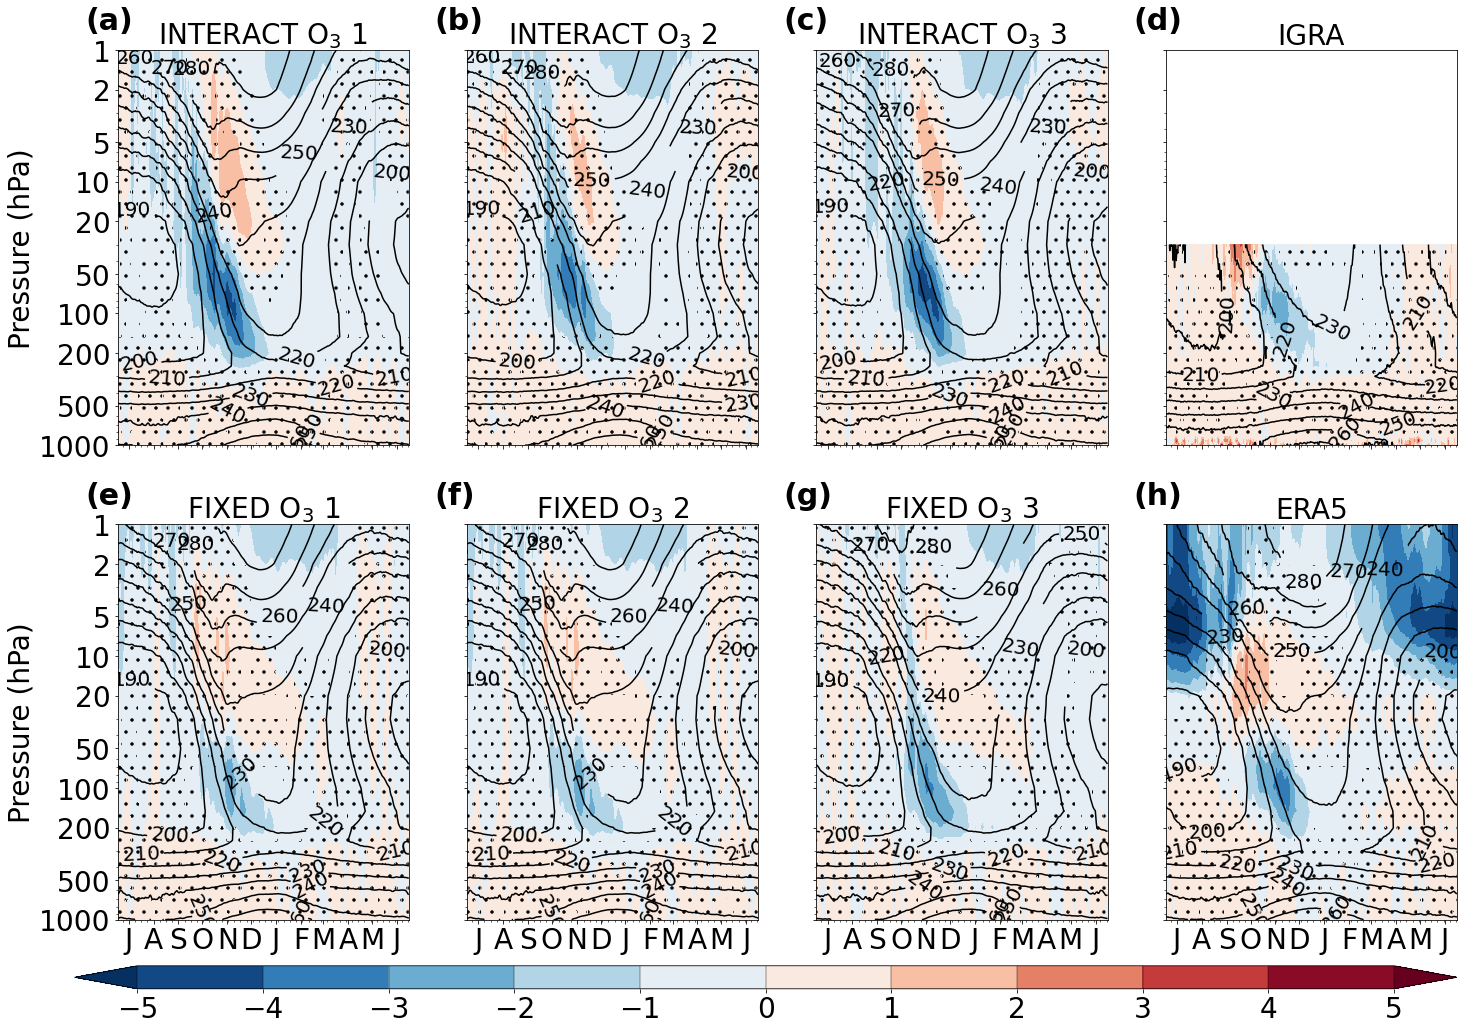

In [77]:
fig = plt.figure(figsize=(24,16))

# Temperature
cont = np.arange(-5,5.1, 1)
cont2 = np.arange(180,300, 10)
ticks = np.arange(-5,5.1, 1)
cont0 = np.arange(-5,5.1, 1)
ticks0 = np.arange(-5,5.1, 1)

con = mon_plev3(sw054f_trend_t, sw054f_signif_t, sw054f_mean_t, cont, cont2, ticks,  'INTERACT O$_3$ 1', 1)
plt.text(-40,0.7, '(a)', fontsize=30, fontweight='bold')
con = mon_plev4(sw064f_trend_t, sw064f_signif_t, sw064f_mean_t, cont, cont2, ticks,  'INTERACT O$_3$ 2', 2)
plt.text(-40,0.7, '(b)', fontsize=30, fontweight='bold')
con = mon_plev4(sw065f_trend_t, sw065f_signif_t, sw065f_mean_t, cont, cont2, ticks, 'INTERACT O$_3$ 3', 3)
plt.text(-40,0.7, '(c)', fontsize=30, fontweight='bold')
con = mon_plev4(igra_trend_t.sel(plev=slice(100000, 3000)), igra_signif_t.sel(plev=slice(100000, 3000)), \
                igra_mean_t.sel(plev=slice(100000, 3000)), cont, cont2, ticks, 'IGRA', 4)
plt.text(-40,0.7, '(d)', fontsize=30, fontweight='bold')


con = mon_plev(sw060f_trend_t, sw060f_signif_t, sw060f_mean_t, cont, cont2, ticks, 'FIXED O$_3$ 1', 5)
plt.text(-40,0.7, '(e)', fontsize=30, fontweight='bold')
con = mon_plev2(sw060f_trend_t, sw060f_signif_t, sw060f_mean_t, cont, cont2, ticks, 'FIXED O$_3$ 2', 6)
plt.text(-40,0.7, '(f)', fontsize=30, fontweight='bold')
con2 = mon_plev2(jh019f_trend_t, jh019f_signif_t, jh019f_mean_t, cont, cont2, ticks, 'FIXED O$_3$ 3', 7)
plt.text(-40,0.7, '(g)', fontsize=30, fontweight='bold')
con2 = mon_plev2(eraf_trend_t, eraf_signif_t, eraf_mean_t, cont, cont2, ticks, 'ERA5', 8)
plt.text(-40,0.7, '(h)', fontsize=30, fontweight='bold')

#cax = plt.axes([0.92, 0.1, 0.02, 0.8])
cax = plt.axes([0.1, 0.065, 0.8, 0.02])
ticks = np.arange(-5,5.1, 1)
c = plt.colorbar(con, ticks=ticks, cax=cax, orientation='horizontal',  drawedges=True)
c.ax.tick_params(labelsize=28)
